# Market Basket Analysis

LSESU Data Science Society Project

In [4]:
#libaries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3 as sql
import pandas.io.sql as pds
from scipy.stats import skewnorm 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [5]:
#import data from csv file
df_csv1 = pd.read_csv("online_retail.csv", encoding="unicode_escape") 
df_csv2 = pd.read_csv("online_retail_II.csv",  encoding="unicode_escape")
df_csv1.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 08:26,3.39,17850.0,United Kingdom


## Cleaning the Data

In [6]:
print(df_csv1.shape)
print(df_csv2.shape)

(541910, 8)
(525461, 8)


In [7]:
df_csv = pd.concat([df_csv1, df_csv2], axis=0)

In [8]:
df_csv.columns = df_csv.columns.str.lower().str.strip()
df_csv.columns

Index(['invoice', 'stockcode', 'description', 'quantity', 'invoicedate',
       'price', 'customer id', 'country'],
      dtype='object')

In [9]:
df_csv.isnull().sum() #check null values

invoice             0
stockcode           0
description      4382
quantity            0
invoicedate         0
price               0
customer id    243007
country             0
dtype: int64

In [10]:
df_csv.shape

(1067371, 8)

total rows 1067371

In [11]:
df_csv.dtypes #check column types

invoice         object
stockcode       object
description     object
quantity         int64
invoicedate     object
price          float64
customer id    float64
country         object
dtype: object

In [12]:
df_csv["invoicedate"] = pd.to_datetime(df_csv["invoicedate"], format="%d/%m/%Y %H:%M")
df_csv.dtypes

invoice                object
stockcode              object
description            object
quantity                int64
invoicedate    datetime64[ns]
price                 float64
customer id           float64
country                object
dtype: object

In [13]:
df_csv = df_csv[df_csv["description"].notna()]
df_csv = df_csv[df_csv["quantity"] > 0]
df_csv = df_csv[df_csv["price"]> 0]
df_csv = df_csv[df_csv["country"] == "United Kingdom"]
df_csv.describe()

,quantity,price,customer id
count,958502.000000,958502.000000,725250.000000
mean,9.789489,4.021459,15559.119094
std,122.667472,51.057409,1593.844795
min,1.000000,0.001000,12346.000000
25%,1.000000,1.250000,14209.000000
50%,3.000000,2.100000,15555.000000
75%,10.000000,4.150000,16938.000000
max,80995.000000,25111.090000,18287.000000


1. Exclude prices below 0
2. Exclude quantity below 0 
3. Exclude NULL descriptions
4. Include only UK transactions

In [14]:
df_csv["description"] = df_csv["description"].str.strip()
df_csv["invoice"] = df_csv["invoice"].astype("str")
df_csv["stockcode"] = df_csv["stockcode"].astype("str")
df_csv.head()

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [15]:
print("Number of unique descriptions")
print(len(df_csv["description"].unique()))
print("Number of unique stockcode")
print(len(df_csv["stockcode"].unique()))

Number of unique descriptions
5327
Number of unique stockcode
4906


Note that there are 421 descriptions that correspond to the same product but is differently discribed. 

In [16]:
white_metal = df_csv[df_csv["description"].str.contains("METAL LANTERN")]
white_metal

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
50,536373,71053,WHITE METAL LANTERN,6,2010-12-01 09:02:00,3.39,17850.0,United Kingdom
67,536375,71053,WHITE METAL LANTERN,6,2010-12-01 09:32:00,3.39,17850.0,United Kingdom
281,536396,71053,WHITE METAL LANTERN,6,2010-12-01 10:51:00,3.39,17850.0,United Kingdom
417,536406,71053,WHITE METAL LANTERN,8,2010-12-01 11:33:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
520021,537678,71053,WHITE METAL LANTERN,24,2010-12-08 09:56:00,3.39,16779.0,United Kingdom
520360,537759,71053,WHITE METAL LANTERN,4,2010-12-08 11:42:00,3.75,13126.0,United Kingdom
521182,537811,71053,WHITE METAL LANTERN,24,2010-12-08 13:30:00,3.39,17262.0,United Kingdom
523065,538010,71053,WHITE METAL LANTERN,4,2010-12-09 12:20:00,3.75,17526.0,United Kingdom


Desctiptions might not be consistent across the same product -  evidence is shown above. Hence, Asssociation Rule Analysis made based on stockcode might be more desirable.

In [17]:
white_metal["description"].unique()

array(['WHITE METAL LANTERN', 'WHITE MOROCCAN METAL LANTERN'],
      dtype=object)

These two discriptions should correspond to the same product.

<AxesSubplot:>

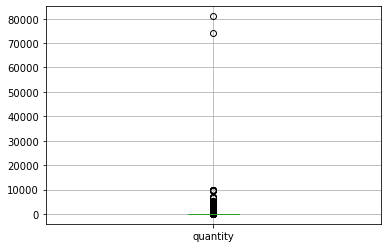

In [18]:
quantity_big = df_csv[df_csv["quantity"] > 10]
quantity_big.boxplot(column = ["quantity"])

In [19]:
bigger= quantity_big[quantity_big["quantity"] > 1000]
bigger

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country
4850,536809,84950,ASSORTED COLOUR T-LIGHT HOLDER,1824,2010-12-02 16:48:00,0.55,15299.0,United Kingdom
4945,536830,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,2880,2010-12-02 17:38:00,0.18,16754.0,United Kingdom
4946,536830,21915,RED HARMONICA IN BOX,1400,2010-12-02 17:38:00,1.06,16754.0,United Kingdom
16435,537659,22189,CREAM HEART CARD HOLDER,1008,2010-12-07 16:43:00,2.31,18102.0,United Kingdom
16436,537659,22188,BLACK HEART CARD HOLDER,1008,2010-12-07 16:43:00,2.31,18102.0,United Kingdom
...,...,...,...,...,...,...,...,...
507883,536830,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,2880,2010-12-02 17:38:00,0.18,16754.0,United Kingdom
507884,536830,21915,RED HARMONICA IN BOX,1400,2010-12-02 17:38:00,1.06,16754.0,United Kingdom
519373,537659,22189,CREAM HEART CARD HOLDER,1008,2010-12-07 16:43:00,2.31,18102.0,United Kingdom
519374,537659,22188,BLACK HEART CARD HOLDER,1008,2010-12-07 16:43:00,2.31,18102.0,United Kingdom


In [20]:
print(quantity_big[quantity_big["invoice"]=="581458"]["description"])
print(quantity_big[quantity_big["invoice"]=="581115"]["description"])
print(len(bigger["invoice"].unique()))

540070    POPCORN HOLDER
Name: description, dtype: object
533812    METAL SIGN TAKE IT OR LEAVE IT
Name: description, dtype: object
139


I suspect a transaction with a very high product quantity might come from a B2B business. A normal customer like you and I will not probably buy a product more than _a certain number_. We can do a rigorous statistical analysis to find _this number_ and then filter out those above it. We would be left with invoice of B2C transactions.

Most B2B transactions will only have one item in their shopping cart. 

<AxesSubplot:>

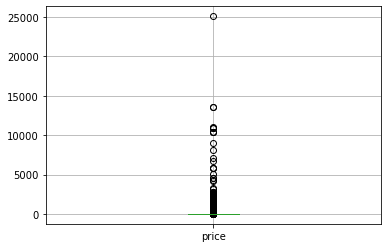

In [21]:
df_csv.boxplot(column = ["price"])

In [22]:
df_csv[df_csv["price"]>2000]

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country
15017,537632,AMAZONFEE,AMAZON FEE,1,2010-12-07 15:08:00,13541.33,NaN,United Kingdom
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029.0,United Kingdom
268028,560373,M,Manual,1,2011-07-18 12:30:00,4287.63,NaN,United Kingdom
297438,562946,M,Manual,1,2011-08-11 09:38:00,2500.00,15581.0,United Kingdom
297725,562955,DOT,DOTCOM POSTAGE,1,2011-08-11 10:14:00,4505.17,NaN,United Kingdom
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom
342997,566927,M,Manual,1,2011-09-15 15:20:00,2033.10,17846.0,United Kingdom
374541,569382,M,Manual,1,2011-10-03 16:44:00,3155.95,15502.0,United Kingdom
431348,573585,DOT,DOTCOM POSTAGE,1,2011-10-31 14:41:00,2019.05,NaN,United Kingdom
493021,578149,DOT,DOTCOM POSTAGE,1,2011-11-23 11:11:00,2275.54,NaN,United Kingdom


The file does include some weird transactions. Some are displayed above. Not all stockcodes represent products as shown above.

In [23]:
df_csv[df_csv["invoice"] == "562946"]

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country
297438,562946,M,Manual,1,2011-08-11 09:38:00,2500.0,15581.0,United Kingdom


1. It's ok for the quantity of a product to be high becausse it's a B2B business
2. Need to figure out a clever way to differentiate between actual product transactions and non product transactions. 
3. Might need to think about segmenting the customers (business and actual customer)

In [24]:
non_product = ['m','gift_0001_50','gift_0001_40','gift_0001_30','gift_0001_20','gift_0001_10',"DOT", "M", "B", "POST", "AMAZONFEE", "BANK CHARGES", 'gift_0001_80',
 'gift_0001_70','TEST002','TEST001','D','C2','ADJUST2','ADJUST',  'S']

for product in non_product:
    df_csv = df_csv[df_csv["stockcode"] !=  product]

1. m: manual
2. gift: voucher
3. POST & DOT: delivery
4. B: debt
5. D: discount
6. ADJUST: Accounting adjustments
7. C2: carriage

In [25]:
print(len(df_csv["stockcode"].unique()))
sorted(list(df_csv["stockcode"].unique()), reverse=True)

4885


['SP1002',
 'PADS',
 'DCGSSGIRL',
 'DCGSSBOY',
 'DCGS0076',
 'DCGS0075',
 'DCGS0072',
 'DCGS0070',
 'DCGS0069',
 'DCGS0068',
 'DCGS0066N',
 'DCGS0062',
 'DCGS0058',
 'DCGS0044',
 'DCGS0041',
 'DCGS0037',
 'DCGS0004',
 'DCGS0003',
 '90214Z',
 '90214Y',
 '90214W',
 '90214V',
 '90214U',
 '90214T',
 '90214S',
 '90214R',
 '90214P',
 '90214O',
 '90214N',
 '90214M',
 '90214L',
 '90214K',
 '90214J',
 '90214I',
 '90214H',
 '90214G',
 '90214F',
 '90214E',
 '90214D',
 '90214C',
 '90214B',
 '90214A',
 '90212C',
 '90212B',
 '90211B',
 '90211A',
 '90210D',
 '90210C',
 '90210B',
 '90210A',
 '90209C',
 '90209B',
 '90209A',
 '90208',
 '90206C',
 '90206A',
 '90205C',
 '90205A',
 '90204',
 '90203',
 '90202D',
 '90202C',
 '90202B',
 '90202A',
 '90201D',
 '90201C',
 '90201B',
 '90201A',
 '90200E',
 '90200D',
 '90200C',
 '90200B',
 '90200A',
 '90199D',
 '90199C',
 '90199B',
 '90199A',
 '90198B',
 '90198A',
 '90197D',
 '90197B',
 '90196B',
 '90196A',
 '90195B',
 '90195A',
 '90194',
 '90192',
 '90191',
 '9019

In [26]:
df_csv[df_csv["stockcode"] == "90211A"]

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country
3036,536592,90211A,DIAMOND LAS VEGAS NECKLACE 45CM,1,2010-12-01 17:06:00,5.94,NaN,United Kingdom
13921,537434,90211A,DIAMOND LAS VEGAS NECKLACE 45CM,2,2010-12-06 16:57:00,5.94,NaN,United Kingdom
37060,539453,90211A,DIAMOND LAS VEGAS NECKLACE 45CM,1,2010-12-17 17:08:00,5.94,NaN,United Kingdom
313888,564544,90211A,DIAMOND LAS VEGAS NECKLACE 45CM,2,2011-08-25 15:50:00,5.95,15663.0,United Kingdom
436445,574149,90211A,DIAMOND LAS VEGAS NECKLACE 45CM,2,2011-11-03 11:29:00,5.95,13709.0,United Kingdom
494977,578288,90211A,DIAMOND LAS VEGAS NECKLACE 45CM,1,2011-11-23 14:05:00,5.95,12748.0,United Kingdom
496547,578344,90211A,DIAMOND LAS VEGAS NECKLACE 45CM,2,2011-11-24 09:21:00,5.82,NaN,United Kingdom
529477,580730,90211A,DIAMOND LAS VEGAS NECKLACE 45CM,1,2011-12-05 17:28:00,5.82,NaN,United Kingdom
30574,491966,90211A,DIAMOND LAS VEGAS NECKLACE 45CM,1,2009-12-14 17:16:00,6.07,NaN,United Kingdom
41259,492783,90211A,DIAMOND LAS VEGAS NECKLACE 45CM,1,2009-12-18 17:15:00,6.07,NaN,United Kingdom


<AxesSubplot:>

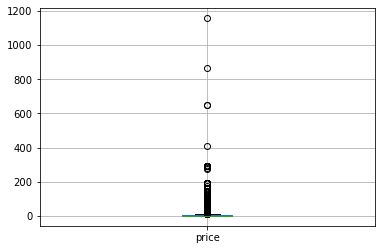

In [27]:
df_csv.boxplot(column = ["price"])

In [28]:
df_csv[df_csv["price"]>200]

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country
4989,536835,22655,VINTAGE RED KITCHEN CABINET,1,2010-12-02 18:06:00,295.00,13145.0,United Kingdom
32484,539080,22655,VINTAGE RED KITCHEN CABINET,1,2010-12-16 08:41:00,295.00,16607.0,United Kingdom
51636,540647,22655,VINTAGE RED KITCHEN CABINET,1,2011-01-10 14:57:00,295.00,17406.0,United Kingdom
82768,543253,22655,VINTAGE RED KITCHEN CABINET,1,2011-02-04 15:32:00,295.00,14842.0,United Kingdom
118748,546480,22656,VINTAGE BLUE KITCHEN CABINET,1,2011-03-14 11:38:00,295.00,13452.0,United Kingdom
134007,547814,22656,VINTAGE BLUE KITCHEN CABINET,1,2011-03-25 14:19:00,295.00,13452.0,United Kingdom
171178,551393,22656,VINTAGE BLUE KITCHEN CABINET,1,2011-04-28 12:22:00,295.00,14973.0,United Kingdom
205759,554836,22655,VINTAGE RED KITCHEN CABINET,1,2011-05-26 16:25:00,295.00,13015.0,United Kingdom
222671,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098.0,United Kingdom
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.50,15098.0,United Kingdom


In [29]:
df_csv.describe()

,quantity,price,customer id
count,955994.00000,955994.000000,724458.000000
mean,9.80261,3.372446,15559.194692
std,122.80328,4.809615,1593.732321
min,1.00000,0.001000,12346.000000
25%,1.00000,1.250000,14209.000000
50%,3.00000,2.100000,15555.000000
75%,10.00000,4.130000,16938.000000
max,80995.00000,1157.150000,18287.000000


In [30]:
df_csv.to_csv("cleaned_data.csv", index=False)

In [31]:
print(df_csv["invoicedate"].max())
print(df_csv["invoicedate"].min())

2011-12-09 12:49:00
2009-12-01 07:45:00


## Using SQL to manipulate the table

In [32]:
# make sure of updating the path to a file
conn = sql.connect('retail.db')

# index = False to ensure the DataFrame row index is not written into the SQL tables
df_csv.to_sql('retail', con = conn, index = False) 

/Users/jaggergarcia/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:2779: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


ValueError: Table 'retail' already exists.

In [33]:
db = 'retail.db'

def run_query(q):
    # Connect to the database
    with sql.connect(db) as conn:
        # Wrapper function to read_sql_query(): returns a DataFrame corresponding to the result set of 
        # the query string
        return pd.read_sql(q,conn)
 
#Function to show all the tables present in the database.

def show_tables():
    q = '''
        SELECT
            name
        FROM sqlite_master
        WHERE type IN ("table","view");
        '''
    return run_query(q)

# Function to count how many rows in each table
def get_table_row_count(tablename):
    q = '''
        SELECT
            COUNT(1)
        FROM %s;
        ''' % tablename
    return run_query(q)["COUNT(1)"][0]

tables = show_tables()
tables["row_count"] = [get_table_row_count(t) for t in tables["name"]]

tables

,name,row_count
0,retail,955994


In [34]:
df_csv = pd.read_csv("cleaned_data.csv")
df_csv.columns

Index(['invoice', 'stockcode', 'description', 'quantity', 'invoicedate',
       'price', 'customer id', 'country'],
      dtype='object')

In [35]:
num_items_query = ''' 
SELECT invoice, COUNT(DISTINCT(stockcode)) "num_items", SUM(quantity) "total_quantity", SUM(quantity * price) "total_amount" 
FROM retail
GROUP BY 1
ORDER BY 4
'''
num_items = run_query(num_items_query)
num_items 

,invoice,num_items,total_quantity,total_amount
0,528127,1,1,0.19
1,570554,1,1,0.38
2,502731,1,1,0.42
3,507293,1,1,0.42
4,518991,1,1,0.42
...,...,...,...,...
36179,533027,111,13387,49844.99
36180,576365,99,13956,50653.91
36181,574941,101,14149,52940.94
36182,541431,1,74215,77183.60


In [36]:
num_items.describe()["total_amount"]

count     36184.000000
mean        476.285134
std        1444.050310
min           0.190000
25%         148.400000
50%         300.130000
75%         471.840000
max      168469.600000
Name: total_amount, dtype: float64

In [37]:
#take bottom third quartile as potential normal customers.

potential_cust = num_items[num_items["total_amount"]<= 471.84]

Total amount is quantity x price.the most expensive 'common' product sold by this seller has a price tag of 295 then we can safetly bet that a normal customer is extremely unlikely to spend more than $471 in one transaction. Therefore, we infer that the top 25% of transactions in term of total_amount comes from wholesalers.

In [38]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    df_low = df_in[(df_in[col_name] < fence_low)]
    df_high = df_in[df_in[col_name] > fence_high]
    return df_out, df_low, df_high

wo_outliers, low_outliers, high_outliers = remove_outlier(potential_cust, "total_amount")
print(wo_outliers.shape)
print(low_outliers.shape)
print(high_outliers.shape)


(27140, 4)
(0, 4)
(0, 4)


          num_items  total_quantity  total_amount
count  27140.000000    27140.000000  27140.000000
mean      16.295873      130.462712    219.133739
std       15.702293      123.682606    126.442958
min        1.000000        1.000000      0.190000
25%        5.000000       48.000000    117.975000
50%       13.000000      104.000000    214.230000
75%       22.000000      181.000000    317.620000
max      175.000000     3186.000000    471.840000


/Users/jaggergarcia/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


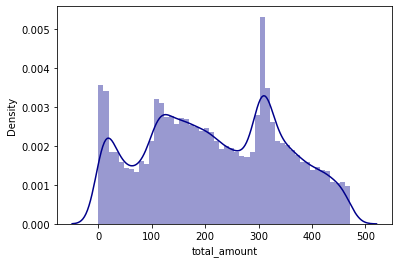

In [39]:
sns.distplot(wo_outliers["total_amount"],kde=True, bins=50, color = 'darkblue'); 
print(wo_outliers.describe())

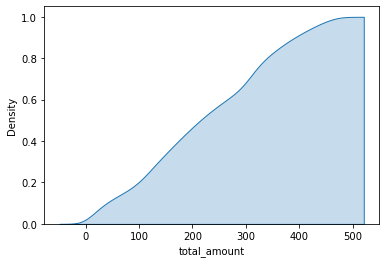

In [40]:
sns.kdeplot(wo_outliers["total_amount"], shade=True, cumulative=True);

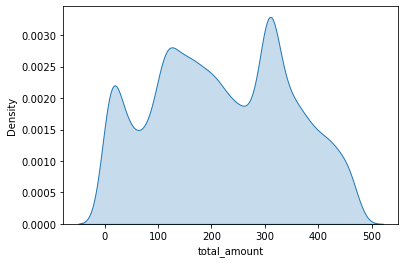

In [41]:
sns.kdeplot(wo_outliers["total_amount"], shade=True);

In [42]:
first = wo_outliers["total_amount"].quantile(0.25)
wo_outliers[wo_outliers["total_amount"]<first]

,invoice,num_items,total_quantity,total_amount
0,528127,1,1,0.19
1,570554,1,1,0.38
2,502731,1,1,0.42
3,507293,1,1,0.42
4,518991,1,1,0.42
...,...,...,...,...
6780,570235,22,50,117.88
6781,553858,13,60,117.89
6782,554090,13,72,117.93
6783,569457,30,61,117.94


In [43]:
#remove outliers in num_items column. removing purchases with extremly high number of different products purchased.
wo_outliers2, low_outliers2, high_outliers2  = remove_outlier(wo_outliers, "num_items")
print(wo_outliers2.shape)
print(low_outliers2.shape)
print(high_outliers2.shape)

(25729, 4)
(0, 4)
(1411, 4)


In [44]:
wo_outliers2.describe()

,num_items,total_quantity,total_amount
count,25729.00000,25729.000000,25729.000000
mean,13.70609,126.695635,213.561955
std,10.85585,123.908526,125.816692
min,1.00000,1.000000,0.190000
25%,5.00000,45.000000,114.060000
50%,12.00000,99.000000,205.480000
75%,20.00000,176.000000,313.400000
max,47.00000,3186.000000,471.840000


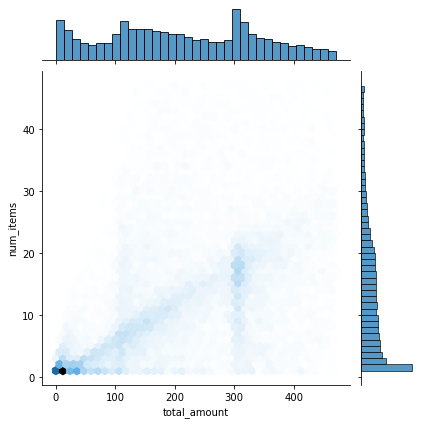

In [45]:
sns.jointplot(x="total_amount", y="num_items", kind = 'hex',data=wo_outliers2)

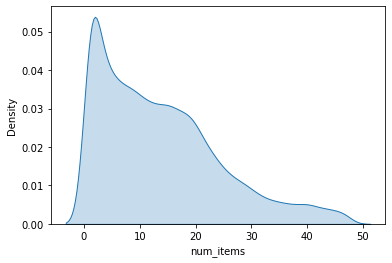

In [46]:
sns.kdeplot(wo_outliers2["num_items"], shade=True);

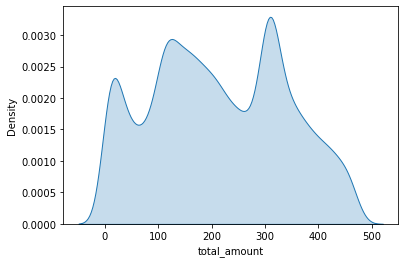

In [47]:
sns.kdeplot(wo_outliers2["total_amount"], shade=True);

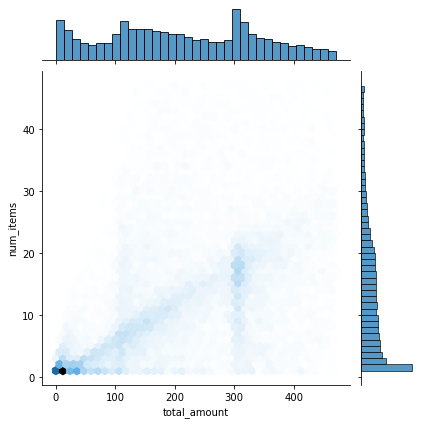

In [48]:
sns.jointplot(x="total_amount", y="num_items",kind="hex", data=wo_outliers2)

In [49]:
#remove outliers in total_quantity column. removing purchases with extremly high quantity of products purchased.
wo_outliers3, low_outliers3, high_outliers3  = remove_outlier(wo_outliers2, "total_quantity")
print(wo_outliers3.shape)
print(low_outliers3.shape)
print(high_outliers3.shape)

(24857, 4)
(0, 4)
(872, 4)


In [50]:
wo_outliers3.describe()

,num_items,total_quantity,total_amount
count,24857.000000,24857.000000,24857.000000
mean,13.616084,112.088587,209.066997
std,10.831345,85.775697,124.662339
min,1.000000,1.000000,0.190000
25%,5.000000,44.000000,111.900000
50%,12.000000,96.000000,199.850000
75%,20.000000,165.000000,310.410000
max,47.000000,372.000000,471.840000


Removing outliers for each columns so that clustering works better. 

We may agree that an extremly high value for each column indicates that the purchase is made by a wholesler rather than a normal customer. 

## Clustering

In [51]:
scaler = StandardScaler()
scaled = scaler.fit_transform(wo_outliers3.drop('invoice',axis=1)) 
scaled = pd.DataFrame(scaled,columns = ['num_items','total_quantity', 'total_amount'])
scaled

,num_items,total_quantity,total_amount
0,-1.164799,-1.295132,-1.675576
1,-1.164799,-1.295132,-1.674052
2,-1.164799,-1.295132,-1.673731
3,-1.164799,-1.295132,-1.673731
4,-1.164799,-1.295132,-1.673731
...,...,...,...
24852,-0.149207,0.278772,2.105995
24853,-0.703166,0.302089,2.105995
24854,1.420343,2.913604,2.107920
24855,0.127772,0.581895,2.107920


In [52]:
scores = []
silhouette = {}
for i in range(2,10):
    kmeans = KMeans(n_clusters = i, max_iter = 40).fit(scaled)
    cluster_labels = kmeans.labels_
    silhouette[i] = silhouette_score(scaled,cluster_labels)
    scores.append(kmeans.inertia_)

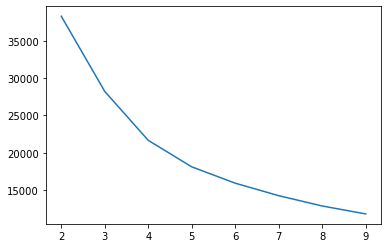

In [53]:
plt.plot(range(2,10,1), scores)

In [54]:
silhouette

{2: 0.4197771632555685,
 3: 0.42411429938550316,
 4: 0.36962739888629353,
 5: 0.3382606487141229,
 6: 0.34006711777445237,
 7: 0.3359678994033028,
 8: 0.3324534697974195,
 9: 0.3222673341515547}

In [55]:
# Final Model
kmeans = KMeans(n_clusters = 2).fit(scaled)
cluster_labels = kmeans.labels_
wo_outliers3['Cluster'] = cluster_labels

<ipython-input-55-75ebe7e1fdd6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wo_outliers3['Cluster'] = cluster_labels


In [56]:
wo_outliers3.head()

,invoice,num_items,total_quantity,total_amount,Cluster
0,528127,1,1,0.19,1
1,570554,1,1,0.38,1
2,502731,1,1,0.42,1
3,507293,1,1,0.42,1
4,518991,1,1,0.42,1


In [57]:
cluster0 = wo_outliers3[wo_outliers3['Cluster']==0] 
cluster0

,invoice,num_items,total_quantity,total_amount,Cluster
4056,574470,25,250,71.70,0
4139,562421,9,264,74.40,0
4174,564164,1,300,75.00,0
4207,508071,7,288,75.72,0
4488,561624,5,352,81.60,0
...,...,...,...,...,...
27133,554142,12,136,471.60,0
27134,575978,6,138,471.60,0
27137,532340,29,362,471.84,0
27138,566705,15,162,471.84,0


In [58]:
cluster1 =wo_outliers3[wo_outliers3['Cluster']==1] 
cluster1

,invoice,num_items,total_quantity,total_amount,Cluster
0,528127,1,1,0.19,1
1,570554,1,1,0.38,1
2,502731,1,1,0.42,1
3,507293,1,1,0.42,1
4,518991,1,1,0.42,1
...,...,...,...,...,...
25523,508739,1,12,419.40,1
25524,542145,1,12,419.40,1
25536,532047,1,6,419.70,1
26250,541426,1,4,440.00,1


<AxesSubplot:xlabel='total_amount', ylabel='Density'>

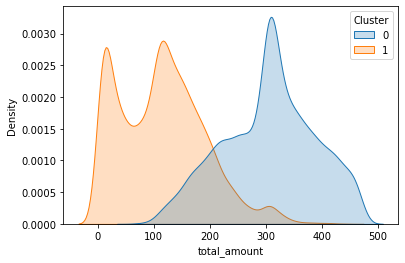

In [59]:
sns.kdeplot(x="total_amount", shade=True, hue="Cluster", data=wo_outliers3)

<AxesSubplot:xlabel='total_quantity', ylabel='Density'>

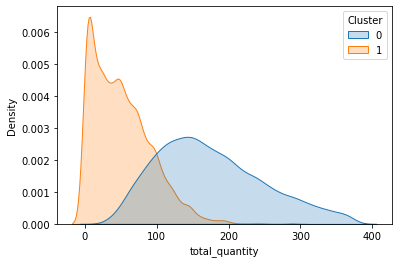

In [60]:
sns.kdeplot(x="total_quantity", shade=True, hue="Cluster", data=wo_outliers3)

<AxesSubplot:xlabel='num_items', ylabel='Density'>

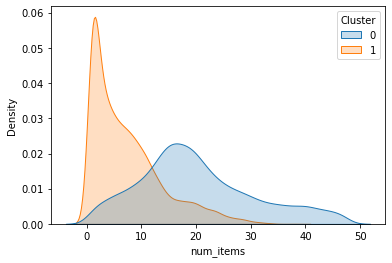

In [61]:
sns.kdeplot(x="num_items", shade=True, hue="Cluster", data=wo_outliers3)

Cluster 0 can be viewed as small customers deduced from the distibutions above while cluster 1 can be view as wholeselers. 

The reasons being:
1. Cluster 0 is positive skewed for all three distributions.
2. Cluster 1 distributions almost fit a normal distribution for all three features. 

Hence, we can conlcude that for each transaction, the majority of cluster 1 prefer to purchase fewer number of different products, fewer quantity and cheaper price tag.

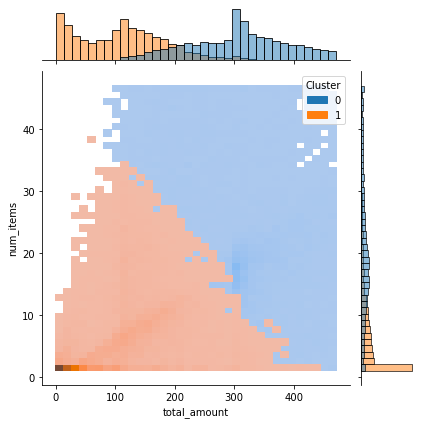

In [62]:
sns.jointplot(x="total_amount", y="num_items", kind="hist", hue="Cluster", data=wo_outliers3)

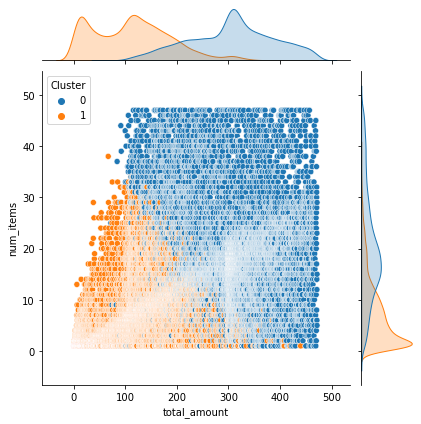

In [63]:
sns.jointplot(x="total_amount", y="num_items", kind="scatter", hue="Cluster", data=wo_outliers3)

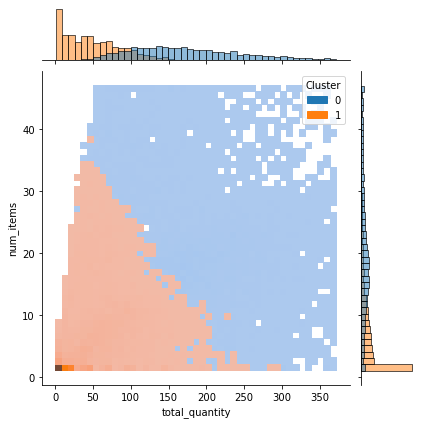

In [64]:
sns.jointplot(x="total_quantity", y="num_items", kind="hist", hue="Cluster", data=wo_outliers3)

In [65]:
#To make the interactive python matplotlib, we need to intsall this library
!pip3 install ipympl

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
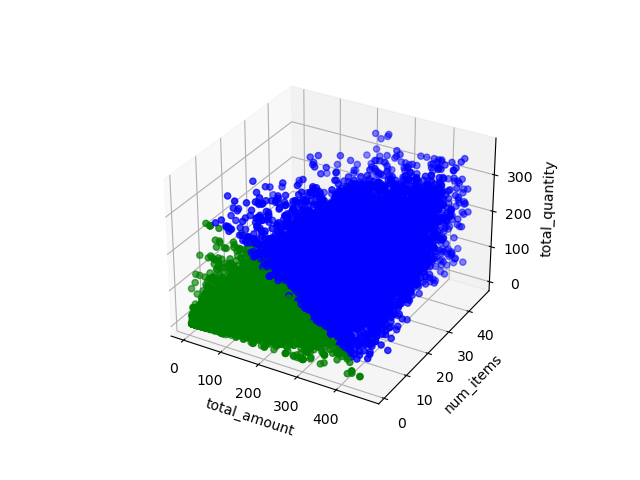

In [66]:
#for creating a responsive plot
%matplotlib widget

#import the libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# Generate the values
x_vals = wo_outliers3["total_amount"]
y_vals = wo_outliers3["num_items"]
z_vals = wo_outliers3["total_quantity"]

# Plot the values
colormap =np.array(["blue", "green"])

ax.scatter(x_vals, y_vals, z_vals, c=colormap[wo_outliers3["Cluster"]], marker='o')
ax.set_xlabel('total_amount')
ax.set_ylabel('num_items')
ax.set_zlabel('total_quantity')

plt.show()

In [67]:
#Percentage of transactions from normal customers.
len(wo_outliers3[wo_outliers3["Cluster"]==0])/len(num_items)

0.3401779792173336

In [68]:
normal_cust = wo_outliers3[wo_outliers3["Cluster"]==0]

n_c_invoices = normal_cust["invoice"]
len(n_c_invoices)

12309

In [69]:
normal_df = df_csv[df_csv["invoice"].isin(n_c_invoices) == True]
normal_df.reset_index(drop=True, inplace=True)
print(len(normal_df))
print(len(normal_df)/len(df_csv))
normal_df.head()

0
0.0


,invoice,stockcode,description,quantity,invoicedate,price,customer id,country


In [70]:
business_df = df_csv[df_csv["invoice"].isin(n_c_invoices) == False]
business_df.reset_index(drop=True, inplace=True)
print(len(business_df))
print(len(business_df)/len(df_csv))
business_df.head()

955994
1.0


,invoice,stockcode,description,quantity,invoicedate,price,customer id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


A bulk of the transactions is from business customers due to its nature of buying a lot of products in one invoice.

In [71]:
conn.close()

## Data Analysis


In [72]:
normal = pd.read_csv("normal_customers.csv")
business = pd.read_csv("business_customers.csv")

In [73]:
normal.head(2)

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [74]:
normal.describe()

,invoice,quantity,price,customer id
count,93027.000000,93027.000000,93027.000000,83757.000000
mean,534534.366012,6.820912,3.764261,15619.467913
std,26227.907737,11.809764,6.035331,1638.328777
min,489435.000000,1.000000,0.001000,12346.000000
25%,511931.000000,1.000000,1.250000,14284.000000
50%,534067.000000,3.000000,2.510000,15611.000000
75%,556539.000000,8.000000,4.950000,17128.000000
max,581586.000000,291.000000,408.400000,18287.000000


In [75]:
business.head(2)

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country
0,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom
1,536367,22745,POPPY'S PLAYHOUSE BEDROOM,6,2010-12-01 08:34:00,2.10,13047.0,United Kingdom


In [76]:
business.describe()

,invoice,quantity,price,customer id
count,862967.000000,862967.000000,862967.000000,640701.000000
mean,537825.702471,10.124034,3.330209,15551.315347
std,26751.898298,129.190673,4.656302,1587.641983
min,489434.000000,1.000000,0.001000,12346.000000
25%,515703.000000,1.000000,1.250000,14194.000000
50%,537643.000000,3.000000,2.100000,15551.000000
75%,561391.000000,10.000000,4.130000,16928.000000
max,581585.000000,80995.000000,1157.150000,18287.000000


In [77]:
normal['CustomerID'] = normal['customer id']
normal.drop('customer id',axis=1,inplace=True)
business['CustomerID'] = business['customer id']
business.drop('customer id',axis=1,inplace=True)

In [238]:
con = sql.connect("retail3.db")
con.execute("DROP TABLE normal")
con.execute("DROP TABLE business")
normal.to_sql("normal",con)
business.to_sql("business",con)

In [79]:
temp = pds.read_sql("SELECT strftime('%m', invoicedate) AS Month, SUM(quantity) AS TotalQuantity FROM normal GROUP BY Month ORDER BY TotalQuantity DESC",con)
plt.figure(figsize=(5,5))
sns.barplot(y = 'TotalQuantity',x = 'Month',data = temp)
plt.title("Total Quantity Sold Per month (Normal Customers)")
plt.show()


temp = pds.read_sql("SELECT strftime('%m', invoicedate) AS Month, SUM(quantity) AS TotalQuantity FROM business GROUP BY Month ORDER BY TotalQuantity DESC",con)
plt.figure(figsize=(5,5))
sns.barplot(y = 'TotalQuantity',x = 'Month',data = temp)
plt.title("Total Quantity Sold Per month (Business Customers)")
plt.show()

DatabaseError: Execution failed on sql 'SELECT strftime('%m', invoicedate) AS Month, SUM(quantity) AS TotalQuantity FROM normal GROUP BY Month ORDER BY TotalQuantity DESC': no such table: normal

1. Both the kinds of customers have made most purchases in the month of November.
2. Business customers have made most purchases in October,November and December, which can be attributed to holiday season and giving presents to employees in the company.
3. Normal customers have similar purchasing patterns in the remaining months.
4. November having most purchases can be attributed to christmas shopping, hence, giving the retailer evidence to increase stock in November and have more discounts as well.


In [ ]:
temp = pds.read_sql("SELECT strftime('%w', invoicedate) AS Day, Total(quantity) AS TotalQuantity FROM normal GROUP BY Day ORDER BY TotalQuantity DESC",con)
plt.figure(figsize=(5,5))
sns.barplot(y = 'TotalQuantity',x = 'Day',data = temp)
plt.title(" Total Quantity Sold Per Day (Normal Customers)")
plt.show()


temp = pds.read_sql("SELECT strftime('%w', invoicedate) AS Day, Total(Quantity) AS TotalQuantity FROM business GROUP BY Day ORDER BY TotalQuantity DESC",con)
plt.figure(figsize=(5,5))
sns.barplot(y = 'TotalQuantity',x = 'Day',data = temp)
plt.title(" Total Quantity Sold Per Day (Business Customers)")
plt.show()

1. Both kinds of customers have made most purchases on Thursday.


In [ ]:
temp = pds.read_sql("SELECT strftime('%H', invoicedate) AS Hour, SUM(quantity) AS TotalQuantity FROM normal GROUP BY Hour ORDER BY TotalQuantity DESC",con)
plt.figure(figsize=(7,7))
sns.barplot(y = 'TotalQuantity',x = 'Hour',data = temp)
plt.title(" Total Quantity Sold Each Hour (Normal Customers)")
plt.show()


temp = pds.read_sql("SELECT strftime('%H', invoicedate) AS Hour, SUM(quantity) AS TotalQuantity FROM business GROUP BY Hour ORDER BY TotalQuantity DESC",con)
plt.figure(figsize=(7,7))
sns.barplot(y = 'TotalQuantity',x = 'Hour',data = temp)
plt.title(" Total Quantity Sold Each Hour (Business Customers)")
plt.show()

In [ ]:
temp = pds.read_sql("SELECT COUNT(CustomerID),description, stockcode FROM normal GROUP BY stockcode ORDER BY COUNT(CustomerID) DESC ",con)
plt.figure(figsize = (7,7))
sns.barplot(y = 'description',x = 'COUNT(CustomerID)',data = temp.iloc[0:25,])
plt.title(" 25 Most Popular Items Bought By Normal Customers")
plt.show()

temp = pds.read_sql("SELECT COUNT(CustomerID),description, stockcode FROM business GROUP BY stockcode ORDER BY COUNT(CustomerID) DESC ",con)
plt.figure(figsize = (7,7))
sns.barplot(y = 'description',x = 'COUNT(CustomerID)',data = temp.iloc[0:25,])
plt.title(" 25 Most Popular Items Bought By Business Customers")
plt.show()

1. The White hanging heart T-light holder is the most popular item in the store followed by the regency 3 tier cake stand, assorted color bird ornament and the red retrospot bag.


In [ ]:
temp = pds.read_sql("SELECT strftime('%m', invoicedate) AS Month,COUNT(CustomerID),description, stockcode FROM normal WHERE Month = '11'  GROUP BY stockcode ORDER BY COUNT(CustomerID) DESC ",con)
plt.figure(figsize = (7,7))
sns.barplot(y = 'description',x = 'COUNT(CustomerID)',data = temp.iloc[0:25,])
plt.title(" 25 Most Popular Items Bought By Normal Customers In The Month Of November")
plt.show()

temp = pds.read_sql("SELECT strftime('%m', invoicedate) AS Month,COUNT(CustomerID),description, stockcode FROM business WHERE Month = '11'  GROUP BY stockcode ORDER BY COUNT(CustomerID) DESC ",con)
plt.figure(figsize = (7,7))
sns.barplot(y = 'description',x = 'COUNT(CustomerID)',data = temp.iloc[0:25,])
plt.title(" 25 Most Popular Items Bought By Business Customers In The Month Of November")
plt.show()

Similar kinds of items were bought by both kinds of customers in November, all relating to the theme of Christmas.

In [ ]:
temp = pds.read_sql("SELECT strftime('%w', invoicedate) AS Day,COUNT(CustomerID),description, stockcode FROM normal WHERE Day = '4'  GROUP BY stockcode ORDER BY COUNT(CustomerID) DESC ",con)
plt.figure(figsize = (7,7))
sns.barplot(y = 'description',x = 'COUNT(CustomerID)',data = temp.iloc[0:25,])
plt.title(" 25 Most Popular Items Bought By Normal Customers On Thursday ")
plt.show()

temp = pds.read_sql("SELECT strftime('%w', invoicedate) AS Day,COUNT(CustomerID),description, stockcode FROM business WHERE Day = '4'  GROUP BY stockcode ORDER BY COUNT(CustomerID) DESC ",con)
plt.figure(figsize = (7,7))
sns.barplot(y = 'description',x = 'COUNT(CustomerID)',data = temp.iloc[0:25,])
plt.title(" 25 Most Popular Items Bought By Business Customers On Thursday ")
plt.show()

In [ ]:
temp = pds.read_sql("SELECT strftime('%H', invoicedate) AS Hour,COUNT(CustomerID),description, stockcode FROM normal WHERE Hour = '12'  GROUP BY stockcode ORDER BY COUNT(CustomerID) DESC ",con)
plt.figure(figsize = (7,7))
sns.barplot(y = 'description',x = 'COUNT(CustomerID)',data = temp.iloc[0:25,])
plt.title(" 25 Most Popular Items Bought By Normal Customers At 12 PM ")
plt.show()

temp = pds.read_sql("SELECT strftime('%H', invoicedate) AS Hour,COUNT(CustomerID),description, stockcode FROM business WHERE Hour = '12'  GROUP BY stockcode ORDER BY COUNT(CustomerID) DESC ",con)
plt.figure(figsize = (7,7))
sns.barplot(y = 'description',x = 'COUNT(CustomerID)',data = temp.iloc[0:25,])
plt.title(" 25 Most Popular Items Bought By Business Customers At 12 PM ")
plt.show()

In [ ]:
temp = pds.read_sql("SELECT CustomerID, COUNT(quantity*price) AS Expenditure FROM normal GROUP BY CustomerID ORDER BY Expenditure DESC",con)
plt.figure(figsize=(20,20))
sns.barplot(y = 'Expenditure', x = 'CustomerID', data = temp.iloc[0:25,])
plt.title(" 25 Normal Customers Spending The Most")
plt.show()

temp = pds.read_sql("SELECT CustomerID, COUNT(quantity*price) AS Expenditure FROM business GROUP BY CustomerID ORDER BY Expenditure DESC",con)
plt.figure(figsize=(20,20))
sns.barplot(y = 'Expenditure', x = 'CustomerID', data = temp.iloc[0:25,])
plt.title(" 25 Business Customers Spending The Most")
plt.show()

In [ ]:
temp = pds.read_sql(" SELECT description, quantity FROM normal WHERE CustomerID = 14606 GROUP BY description ORDER BY quantity DESC",con)
plt.figure(figsize = (7,7))
sns.barplot(x = 'quantity',y = 'description',data = temp.iloc[0:25,])
plt.title(" 25 Most Purchases Made By Normal Customer with ID = 14606")
plt.show()

temp = pds.read_sql(" SELECT description, quantity FROM business WHERE CustomerID = 17841 GROUP BY description ORDER BY quantity DESC",con)
plt.figure(figsize = (7,7))
sns.barplot(x = 'quantity',y = 'description',data = temp.iloc[0:25,])
plt.title(" 25 Most Purchases Made By Business Customer with ID = 17841")
plt.show()

The business customer with ID 17841 has bought christmas decorations and office supplies most.

In [ ]:
con.close()

## Apriori Algorithm 

In [128]:
normal_pivot = normal.pivot_table(values = 'quantity',columns = 'stockcode',index = 'invoice')
business_pivot = business.pivot_table(values = 'quantity',columns = 'stockcode',index = 'invoice')


In [239]:
normal_pivot = normal_pivot.fillna(0)
business_pivot = business_pivot.fillna(0)

normal_pivot = normal_pivot.transform(lambda x : np.where(x!=0,x.name,x))
business_pivot = business_pivot.transform(lambda x : np.where(x!=0, x.name,x))

## Normal Transactions

In [174]:
transaction_array_norm = normal_pivot.values.tolist()

In [175]:
transaction_array_clean = []
for i in transaction_array_norm:
    a = [j for j in i if j!= '0.0']
    transaction_array_clean.append(a)

Removing 0's

In [176]:
flat_trans_array = [i for j in transaction_array_clean for i in j]
len(flat_trans_array)

90754

Creating list of all items to count occurances

In [177]:
count_dict = {}
for i in flat_trans_array:
    if i not in count_dict.keys():
        item_count = flat_trans_array.count(i)
        count_dict[i] = item_count

In [178]:
count_dict

{'22195': 54,
 '22349': 45,
 '22350': 33,
 '22353': 39,
 '90003B': 2,
 '90003C': 2,
 '90003D': 3,
 '90082D': 5,
 '90185B': 3,
 '90185C': 2,
 '90200A': 9,
 '90200B': 8,
 '90200C': 5,
 '90200D': 12,
 '90200E': 8,
 '90209A': 4,
 '90209C': 7,
 '21472': 30,
 '21479': 77,
 '21929': 150,
 '22086': 209,
 '22138': 249,
 '22139': 245,
 '22275': 43,
 '47566B': 93,
 '48185': 133,
 '85099B': 378,
 '85226C': 7,
 '85227': 25,
 '21034': 416,
 '21582': 2,
 '21587': 23,
 '21590': 48,
 '21591': 36,
 '22111': 203,
 '22112': 232,
 '71477': 98,
 '72801E': 1,
 '79029': 59,
 '82483': 131,
 '82486': 185,
 '85042': 48,
 '85123A': 858,
 '21353': 2,
 '21533': 104,
 '21534': 56,
 '21535': 126,
 '21538': 13,
 '21540': 19,
 '21754': 330,
 '21755': 256,
 '21756': 83,
 '22073': 34,
 '22118': 32,
 '22203': 30,
 '22300': 63,
 '79067': 55,
 '84352': 24,
 '84836': 156,
 '84946': 267,
 '84970S': 167,
 '85053': 31,
 '21098': 54,
 '21890': 54,
 '21891': 66,
 '22114': 182,
 '22415': 37,
 '85048': 72,
 '20901': 2,
 '21156': 75

Counting instances of each item

In [179]:
len(count_dict)

4306

In [180]:
support_threshold = 100
high_support = {}
for i,j in count_dict.items():
    if j > support_threshold:
        high_support[i] = j

Defining support threshold & removing values below it

In [181]:
high_support

{'21929': 150,
 '22086': 209,
 '22138': 249,
 '22139': 245,
 '48185': 133,
 '85099B': 378,
 '21034': 416,
 '22111': 203,
 '22112': 232,
 '82483': 131,
 '82486': 185,
 '85123A': 858,
 '21533': 104,
 '21535': 126,
 '21754': 330,
 '21755': 256,
 '84836': 156,
 '84946': 267,
 '84970S': 167,
 '22114': 182,
 '84755': 132,
 '84879': 363,
 '85099C': 206,
 '21326': 108,
 '21622': 107,
 '20713': 104,
 '21931': 193,
 '85152': 134,
 '21527': 121,
 '22197': 205,
 '21485': 168,
 '21930': 112,
 '22083': 113,
 '21166': 134,
 '21175': 134,
 '48111': 118,
 '84029E': 133,
 '15056BL': 105,
 '15056N': 125,
 '21181': 164,
 '22147': 105,
 '21212': 149,
 '22082': 118,
 '20726': 124,
 '21843': 166,
 '21231': 120,
 '21217': 103,
 '20725': 196,
 '82482': 230,
 '82494L': 262,
 '20685': 188,
 '21733': 226,
 '21232': 246,
 '22173': 110,
 '22296': 112,
 '20724': 116,
 '21790': 137,
 '22178': 271,
 '84970L': 114,
 '22149': 133,
 '21080': 188,
 '22090': 154,
 '85066': 158,
 '21955': 130,
 '48173C': 104,
 '85099F': 170

In [182]:
len(high_support)

145

In [183]:
high_support_items = list(high_support.keys())
trans_array_prune = []
for transaction in transaction_array_clean:
    if any(x in transaction for x in high_support_items):
        trans_array_prune.append(transaction)

Removing transactions that do not contain instances of high support items

In [184]:
item_set_support = {}
for item1 in high_support.keys():
    supp_dict = {}
    for item2 in high_support.keys():
        if item2 != item1:
            pair_count = 0
            for transaction in trans_array_prune:
                if item2 in transaction and item1 in transaction:
                    pair_count += 1
            supp_dict[item2] = pair_count
    item_set_support[item1] = supp_dict

Calculating support of item sets - lengthy iteration process requires assesing every possible pair of high support items

In [185]:
item_set_support

{'21929': {'22086': 4,
  '22138': 3,
  '22139': 3,
  '48185': 7,
  '85099B': 52,
  '21034': 6,
  '22111': 3,
  '22112': 2,
  '82483': 2,
  '82486': 4,
  '85123A': 15,
  '21533': 4,
  '21535': 4,
  '21754': 3,
  '21755': 2,
  '84836': 2,
  '84946': 1,
  '84970S': 2,
  '22114': 3,
  '84755': 2,
  '84879': 1,
  '85099C': 33,
  '21326': 0,
  '21622': 3,
  '20713': 13,
  '21931': 36,
  '85152': 7,
  '21527': 4,
  '22197': 4,
  '21485': 1,
  '21930': 18,
  '22083': 1,
  '21166': 1,
  '21175': 1,
  '48111': 2,
  '84029E': 2,
  '15056BL': 1,
  '15056N': 3,
  '21181': 2,
  '22147': 0,
  '21212': 3,
  '22082': 1,
  '20726': 5,
  '21843': 2,
  '21231': 1,
  '21217': 2,
  '20725': 5,
  '82482': 6,
  '82494L': 6,
  '20685': 5,
  '21733': 3,
  '21232': 4,
  '22173': 2,
  '22296': 1,
  '20724': 9,
  '21790': 1,
  '22178': 2,
  '84970L': 2,
  '22149': 1,
  '21080': 7,
  '22090': 2,
  '85066': 0,
  '21955': 4,
  '48173C': 1,
  '85099F': 43,
  '21936': 3,
  '72741': 1,
  '22189': 0,
  '48187': 7,
  '481

In [186]:
frequent_item_sets = {}
for i,j in item_set_support.items():
    common_dict = {}
    for k,l in j.items():
        if l > support_threshold:
            common_dict[k] = l
    if not len(common_dict.keys()) == 0:
        frequent_item_sets[i] = common_dict

frequent_item_sets

{'85123A': {'21733': 138},
 '21754': {'21755': 120},
 '21755': {'21754': 120},
 '82482': {'82494L': 108},
 '82494L': {'82482': 108},
 '21733': {'85123A': 138},
 '22469': {'22470': 125},
 '22470': {'22469': 125},
 '22699': {'22697': 102},
 '22697': {'22699': 102}}

Ones below threshold are removed

In [187]:
frequent_item_sets_conf = {}
for antecedent,consequents in frequent_item_sets.items():
    for consequent in consequents:
        data_dict = {}
        pair = (antecedent,consequent)
        ant_conf = consequents[consequent]/high_support[antecedent]
        cons_conf = consequents[consequent]/high_support[consequent]
        data_dict[pair] = (ant_conf,cons_conf)
        frequent_item_sets_conf[antecedent] = data_dict    

Antecedent and consequent confidence calculated for common item sets

In [188]:
frequent_item_sets_conf

{'85123A': {('85123A', '21733'): (0.16083916083916083, 0.6106194690265486)},
 '21754': {('21754', '21755'): (0.36363636363636365, 0.46875)},
 '21755': {('21755', '21754'): (0.46875, 0.36363636363636365)},
 '82482': {('82482', '82494L'): (0.46956521739130436, 0.4122137404580153)},
 '82494L': {('82494L', '82482'): (0.4122137404580153, 0.46956521739130436)},
 '21733': {('21733', '85123A'): (0.6106194690265486, 0.16083916083916083)},
 '22469': {('22469', '22470'): (0.4166666666666667, 0.4139072847682119)},
 '22470': {('22470', '22469'): (0.4139072847682119, 0.4166666666666667)},
 '22699': {('22699', '22697'): (0.6496815286624203, 0.7083333333333334)},
 '22697': {('22697', '22699'): (0.7083333333333334, 0.6496815286624203)}}

In [189]:
conf_threshold = 0.5
high_conf = {}
for antecedent,cons_dicts in frequent_item_sets_conf.items():
    for data_set in cons_dicts:
        conf_entry = {}
        if cons_dicts[data_set][0] > conf_threshold:
            conf_entry[data_set[0]] = (cons_dicts[data_set][0],data_set[1])
        if cons_dicts[data_set][1] > conf_threshold:
            conf_entry[data_set[1]] = (cons_dicts[data_set][1],data_set[0])
    if len(conf_entry.keys()) != 0:
        high_conf[antecedent] = conf_entry
        
high_conf

{'85123A': {'21733': (0.6106194690265486, '85123A')},
 '21733': {'21733': (0.6106194690265486, '85123A')},
 '22699': {'22699': (0.6496815286624203, '22697'),
  '22697': (0.7083333333333334, '22699')},
 '22697': {'22697': (0.7083333333333334, '22699'),
  '22699': (0.6496815286624203, '22697')}}

Values below threshold are removed 

In [190]:
lift_dict_normal = {}
for i,j in high_conf.items():
    for k,l in j.items():
        lift = l[0]/(high_support[l[1]]/len(transaction_array_clean))
        entry = k+'->'+l[1]
        lift_dict_normal[entry] = round(lift,3)
lift_dict_normal

{'21733->85123A': 8.898, '22699->22697': 56.41, '22697->22699': 56.41}

Lift calculated for remaining itemsets and process repeated for business customers

## Business Transactions

In [191]:
transaction_array_norm = business_pivot.values.tolist()
transaction_array_clean = []
for i in transaction_array_norm:
    a = [j for j in i if j!= '0.0']
    transaction_array_clean.append(a)

In [192]:
flat_trans_array = [i for j in transaction_array_clean for i in j]
len(flat_trans_array)

821709

In [194]:
count_dict = {}
for i in flat_trans_array:
    if i not in count_dict.keys():
        item_count = flat_trans_array.count(i)
        count_dict[i] = item_count

In [195]:
count_dict

{'21232': 2014,
 '21523': 883,
 '21871': 669,
 '22041': 476,
 '22064': 604,
 '79323P': 221,
 '79323W': 287,
 '85048': 413,
 '21181': 1578,
 '21333': 177,
 '21754': 1671,
 '21755': 1399,
 '21756': 473,
 '22107': 329,
 '22109': 565,
 '22111': 1407,
 '22119': 276,
 '22142': 443,
 '22194': 126,
 '22295': 608,
 '22296': 690,
 '35004B': 252,
 '48173C': 379,
 '82582': 724,
 '84596F': 537,
 '84596L': 240,
 '84879': 2284,
 '10002': 264,
 '20695': 57,
 '20703': 107,
 '20971': 1023,
 '21351': 150,
 '21352': 142,
 '21360': 81,
 '21364': 141,
 '21912': 705,
 '21987': 270,
 '21989': 520,
 '22112': 1420,
 '22130': 344,
 '22143': 61,
 '22145': 166,
 '22271': 648,
 '22272': 237,
 '22274': 542,
 '35400': 345,
 '37370': 410,
 '84507B': 103,
 '84970S': 1186,
 '20711': 920,
 '21033': 523,
 '21100': 238,
 '21252': 18,
 '21329': 509,
 '21410': 127,
 '21411': 510,
 '84031A': 285,
 '84031B': 245,
 '84032A': 611,
 '84032B': 541,
 '84519A': 176,
 '84519B': 193,
 '85132A': 221,
 '85132C': 261,
 '85183A': 115,
 '8

In [196]:
len(count_dict)

4845

In [197]:
support_threshold = 1000
high_support = {}
for i,j in count_dict.items():
    if j > support_threshold:
        high_support[i] = j

In [198]:
high_support

{'21232': 2014,
 '21181': 1578,
 '21754': 1671,
 '21755': 1399,
 '22111': 1407,
 '84879': 2284,
 '20971': 1023,
 '22112': 1420,
 '84970S': 1186,
 '22138': 1389,
 '21790': 1650,
 '85123A': 4303,
 '82580': 1204,
 '85150': 1007,
 '21929': 1368,
 '22219': 1024,
 '20724': 1641,
 '20725': 2558,
 '20726': 1547,
 '20728': 1761,
 '21485': 1113,
 '21733': 1447,
 '21928': 1318,
 '22083': 1212,
 '22086': 1752,
 '22114': 1323,
 '22178': 1489,
 '22356': 1323,
 '85099B': 3334,
 '21731': 1085,
 '21977': 1691,
 '22139': 1576,
 '84991': 1818,
 '21212': 2561,
 '82486': 1059,
 '82494L': 1652,
 '20972': 1256,
 '21231': 1288,
 '21930': 1172,
 '20719': 1192,
 '21791': 1104,
 '21931': 2035,
 '84946': 1464,
 '85152': 1292,
 '20685': 1363,
 '21166': 1212,
 '21174': 1030,
 '21175': 1466,
 '22077': 1447,
 '22197': 1957,
 '48194': 1079,
 '82600': 1075,
 '20712': 1111,
 '20713': 1137,
 '20727': 2038,
 '21034': 1467,
 '22189': 1090,
 '22355': 1462,
 '21080': 1686,
 '20914': 1666,
 '85099C': 1616,
 '20718': 1012,
 '2

In [199]:
len(high_support)

101

In [200]:
high_support_items = list(high_support.keys())
trans_array_prune = []
for transaction in transaction_array_clean:
    if any(x in transaction for x in high_support_items):
        trans_array_prune.append(transaction)

In [201]:
item_set_support = {}
for item1 in high_support.keys():
    supp_dict = {}
    for item2 in high_support.keys():
        if item2 != item1:
            pair_count = 0
            for transaction in trans_array_prune:
                if item2 in transaction and item1 in transaction:
                    pair_count += 1
            supp_dict[item2] = pair_count
    item_set_support[item1] = supp_dict

In [202]:
item_set_support

{'21232': {'21181': 284,
  '21754': 276,
  '21755': 242,
  '22111': 216,
  '84879': 195,
  '20971': 242,
  '22112': 244,
  '84970S': 243,
  '22138': 174,
  '21790': 313,
  '85123A': 690,
  '82580': 322,
  '85150': 237,
  '21929': 259,
  '22219': 302,
  '20724': 494,
  '20725': 476,
  '20726': 298,
  '20728': 290,
  '21485': 162,
  '21733': 223,
  '21928': 234,
  '22083': 257,
  '22086': 235,
  '22114': 285,
  '22178': 291,
  '22356': 429,
  '85099B': 543,
  '21731': 300,
  '21977': 411,
  '22139': 261,
  '84991': 497,
  '21212': 607,
  '82486': 145,
  '82494L': 251,
  '20972': 269,
  '21231': 966,
  '21930': 225,
  '20719': 390,
  '21791': 224,
  '21931': 392,
  '84946': 326,
  '85152': 228,
  '20685': 241,
  '21166': 229,
  '21174': 247,
  '21175': 317,
  '22077': 283,
  '22197': 412,
  '48194': 177,
  '82600': 215,
  '20712': 279,
  '20713': 285,
  '20727': 363,
  '21034': 123,
  '22189': 215,
  '22355': 452,
  '21080': 357,
  '20914': 344,
  '85099C': 322,
  '20718': 277,
  '21621':

In [203]:
frequent_item_sets = {}
for i,j in item_set_support.items():
    common_dict = {}
    for k,l in j.items():
        if l > support_threshold:
            common_dict[k] = l
    if not len(common_dict.keys()) == 0:
        frequent_item_sets[i] = common_dict

frequent_item_sets

{'85123A': {'21733': 1031},
 '20725': {'20727': 1084, '22383': 1032},
 '21733': {'85123A': 1031},
 '85099B': {'21931': 1205, '85099F': 1063, '22386': 1250, '22411': 1047},
 '84991': {'21212': 1050},
 '21212': {'84991': 1050},
 '21931': {'85099B': 1205},
 '20727': {'20725': 1084},
 '85099F': {'85099B': 1063},
 '22383': {'20725': 1032},
 '22386': {'85099B': 1250},
 '22411': {'85099B': 1047}}

In [204]:
frequent_item_sets_conf = {}
for antecedent,consequents in frequent_item_sets.items():
    for consequent in consequents:
        data_dict = {}
        pair = (antecedent,consequent)
        ant_conf = consequents[consequent]/high_support[antecedent]
        cons_conf = consequents[consequent]/high_support[consequent]
        data_dict[pair] = (ant_conf,cons_conf)
        frequent_item_sets_conf[antecedent] = data_dict    

In [205]:
frequent_item_sets_conf

{'85123A': {('85123A', '21733'): (0.23960027887520335, 0.7125086385625432)},
 '20725': {('20725', '22383'): (0.4034401876465989, 0.5004849660523764)},
 '21733': {('21733', '85123A'): (0.7125086385625432, 0.23960027887520335)},
 '85099B': {('85099B', '22411'): (0.3140371925614877, 0.5533826638477801)},
 '84991': {('84991', '21212'): (0.5775577557755776, 0.4099960952752831)},
 '21212': {('21212', '84991'): (0.4099960952752831, 0.5775577557755776)},
 '21931': {('21931', '85099B'): (0.5921375921375921, 0.3614277144571086)},
 '20727': {('20727', '20725'): (0.5318940137389597, 0.42376856919468336)},
 '85099F': {('85099F', '85099B'): (0.6689741976085588, 0.3188362327534493)},
 '22383': {('22383', '20725'): (0.5004849660523764, 0.4034401876465989)},
 '22386': {('22386', '85099B'): (0.6638343069569835, 0.3749250149970006)},
 '22411': {('22411', '85099B'): (0.5533826638477801, 0.3140371925614877)}}

In [206]:
conf_threshold = 0.5
high_conf = {}
for antecedent,cons_dicts in frequent_item_sets_conf.items():
    for data_set in cons_dicts:
        conf_entry = {}
        if cons_dicts[data_set][0] > conf_threshold:
            conf_entry[data_set[0]] = (cons_dicts[data_set][0],data_set[1])
        if cons_dicts[data_set][1] > conf_threshold:
            conf_entry[data_set[1]] = (cons_dicts[data_set][1],data_set[0])
    if len(conf_entry.keys()) != 0:
        high_conf[antecedent] = conf_entry
        
high_conf

{'85123A': {'21733': (0.7125086385625432, '85123A')},
 '20725': {'22383': (0.5004849660523764, '20725')},
 '21733': {'21733': (0.7125086385625432, '85123A')},
 '85099B': {'22411': (0.5533826638477801, '85099B')},
 '84991': {'84991': (0.5775577557755776, '21212')},
 '21212': {'84991': (0.5775577557755776, '21212')},
 '21931': {'21931': (0.5921375921375921, '85099B')},
 '20727': {'20727': (0.5318940137389597, '20725')},
 '85099F': {'85099F': (0.6689741976085588, '85099B')},
 '22383': {'22383': (0.5004849660523764, '20725')},
 '22386': {'22386': (0.6638343069569835, '85099B')},
 '22411': {'22411': (0.5533826638477801, '85099B')}}

In [207]:
lift_dict_business = {}
for i,j in high_conf.items():
    for k,l in j.items():
        lift = l[0]/(high_support[l[1]]/len(transaction_array_clean))
        entry = k+'->'+l[1]
        lift_dict_business[entry] = round(lift,3)
lift_dict_business

{'21733->85123A': 3.921,
 '22383->20725': 4.633,
 '22411->85099B': 3.931,
 '84991->21212': 5.341,
 '21931->85099B': 4.206,
 '20727->20725': 4.924,
 '85099F->85099B': 4.752,
 '22386->85099B': 4.715}

In [208]:
lift_dict_normal

{'21733->85123A': 8.898, '22699->22697': 56.41, '22697->22699': 56.41}

In [231]:
code = {}
for i in lift_dict_normal:
    temp = i.split('->')
    for s in temp:
        code[s] = normal['description'][normal['stockcode'] == s].unique()[0]

In [232]:
code

{'21733': 'RED HANGING HEART T-LIGHT HOLDER',
 '85123A': 'WHITE HANGING HEART T-LIGHT HOLDER',
 '22699': 'ROSES REGENCY TEACUP AND SAUCER',
 '22697': 'GREEN REGENCY TEACUP AND SAUCER'}

In [233]:
code = {}
for i in lift_dict_business:
    temp = i.split('->')
    for s in temp:
        code[s] = business['description'][business['stockcode'] == s].unique()[0]

In [234]:
code

{'21733': 'RED HANGING HEART T-LIGHT HOLDER',
 '85123A': 'WHITE HANGING HEART T-LIGHT HOLDER',
 '22383': 'LUNCH BAG SUKI  DESIGN',
 '20725': 'LUNCH BAG RED RETROSPOT',
 '22411': 'JUMBO SHOPPER VINTAGE RED PAISLEY',
 '85099B': 'JUMBO BAG RED RETROSPOT',
 '84991': '60 TEATIME FAIRY CAKE CASES',
 '21212': 'PACK OF 72 RETROSPOT CAKE CASES',
 '21931': 'JUMBO STORAGE BAG SUKI',
 '20727': 'LUNCH BAG  BLACK SKULL.',
 '85099F': 'JUMBO BAG STRAWBERRY',
 '22386': 'JUMBO BAG PINK POLKADOT'}

Releant item names displayed for referance